## Linear models

### SVD 

In [1]:
import numpy as np

import torch
from torch import nn

from maestro.layers.linear import MaestroLinear


In [2]:
class LowRankFactorization(nn.Module):
    def __init__(self, m: int, n: int):
        super(LowRankFactorization, self).__init__()
        self.svd = MaestroLinear(m, n, bias=False)

    def forward(self, x, p=None):
        out = self.svd(x, p)
        return out


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
m, n, h = 9, 6, 3
max_r = min(m, n)

# rank h matrix
torch.manual_seed(123)
C = torch.mm(torch.randn(m, h), torch.randn(h, n)).to(device)
U, S, Vh = torch.linalg.svd(C)

In [5]:
print(f"C={C.size()}, U={U.size()}, Vh={Vh.size()}")

C=torch.Size([9, 6]), U=torch.Size([9, 9]), Vh=torch.Size([6, 6])


In [6]:
lr = 0.5
iters = 2000
freq = 100

In [7]:
from maestro.samplers import SingleLayerSampler

In [8]:
best_ranks = []
best_rank = 0
for i in range(max_r):
    best_rank += torch.outer(U[:, i] * S[i], Vh[i,:])
    best_ranks.append(best_rank.clone())

In [9]:
model = LowRankFactorization(m, n).to(device)
optimiser = torch.optim.SGD(model.parameters(), lr=lr)

criterion = nn.MSELoss()

In [10]:
sampler = SingleLayerSampler(model)

losses = [[] for _ in range(max_r)]
eigenvalues = [[] for _ in range(max_r)]


for it in range(iters):
    optimiser.zero_grad(set_to_none=True)

    x = torch.eye(m).to(device)
    p = sampler()

    out = model(x, p)
    loss = criterion(out, torch.mm(x, C))
    loss.backward()
    optimiser.step()

    if it % freq == 0 or it + 1 == iters:
        with torch.no_grad():
            x = torch.eye(m).to(device)
            for r in range(max_r):
                p = (r + 1) / max_r
                output = model(x, p)
                dist = torch.dist(output, best_ranks[r])**2
                losses[r].append(dist.item())
                # eig_value = torch.norm(model.svd.weight_a[r, :]) * torch.norm(model.svd.weight_b[:, r])
                eig_value = torch.norm(model.svd.in_network.weight[r, :]) * torch.norm(model.svd.out_network.weight[:, r])
                eigenvalues[r].append(
                    eig_value.item()
                )
        print(f"{it + 1}/{iters}... Loss of full network:{losses[max_r-1][-1]}")

1/2000... Loss of full network:150.818603515625
101/2000... Loss of full network:0.43086951971054077
201/2000... Loss of full network:0.12433365732431412
301/2000... Loss of full network:0.11160316318273544
401/2000... Loss of full network:0.09967435151338577
501/2000... Loss of full network:0.06982042640447617
601/2000... Loss of full network:0.04909165948629379
701/2000... Loss of full network:0.032544948160648346
801/2000... Loss of full network:0.034256596118211746
901/2000... Loss of full network:0.021495459601283073
1001/2000... Loss of full network:0.014180338941514492
1101/2000... Loss of full network:0.011020207777619362
1201/2000... Loss of full network:0.006850331090390682
1301/2000... Loss of full network:0.010483640246093273
1401/2000... Loss of full network:0.010460156947374344
1501/2000... Loss of full network:0.008647212758660316
1601/2000... Loss of full network:0.006191997788846493
1701/2000... Loss of full network:0.004579093307256699
1801/2000... Loss of full networ

In [11]:
%matplotlib inline

import matplotlib.pyplot as plt

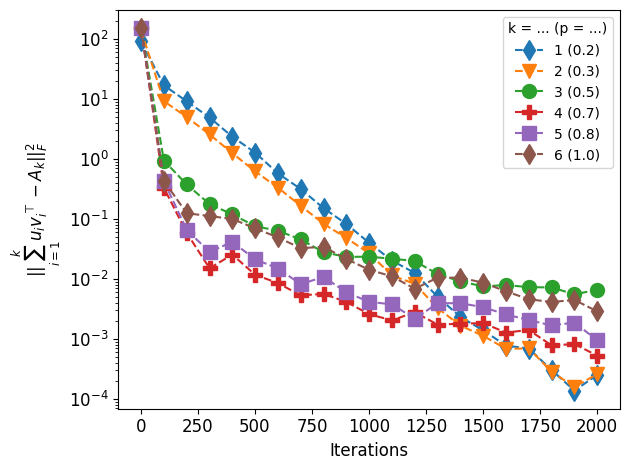

In [12]:
markers = ['d', 'v', 'o', 'P', 's', 'd', 'v', 'o', 'P', 's']

x_vals = np.arange(len(losses[0])) * freq + 1
plt.yscale('log')
for k in range(max_r):
    plt.plot(x_vals, losses[k],'--', marker=markers[k], markersize=10)

plt.legend([str(k+1) + ' (' + str(round((k+1)/max_r, 1)) + ')' for k in range(max_r)], title=r'k = ... (p = ...)')
plt.ylabel(r'$ ||\sum_{i=1}^k u_i v_i^\top - A_k||^2_F$', size=12)
plt.xlabel('Iterations', size=12)
plt.xticks(size=12)
plt.yticks(size=12)
plt.tight_layout()
# plt.savefig('../plots/svd_decomposition.pdf')
plt.show()

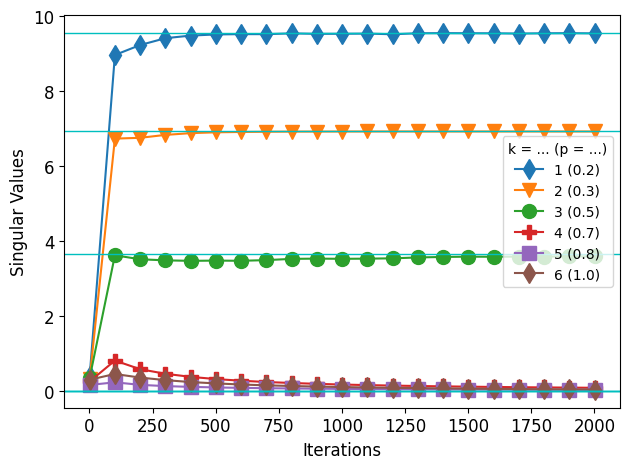

In [13]:
markers = ['d', 'v', 'o', 'P', 's', 'd', 'v', 'o', 'P', 's']

eigvals = S.cpu().numpy()
x_vals = np.arange(len(losses[0])) * freq + 1
for k in range(max_r):
    plt.plot(x_vals, eigenvalues[k],'-', marker=markers[k], markersize=10)

for eigval in eigvals:
    plt.axhline(y=eigval, color='c', linewidth=1.)
plt.legend([str(k+1) + ' (' + str(round((k+1)/max_r, 1)) + ')' for k in range(max_r)], title=r'k = ... (p = ...)')
plt.ylabel('Singular Values', size=12)
plt.xlabel('Iterations', size=12)
plt.xticks(size=12)
plt.yticks(size=12)
plt.tight_layout()
# plt.savefig('../plots/svd_eigenvalues.pdf')
plt.show()

### PCA

In [14]:
import numpy as np

import torch
from torch import nn

from maestro.layers.linear import MaestroLinear

In [15]:
class LowRankFactorization(nn.Module):
    def __init__(self, m: int, n: int):
        super(LowRankFactorization, self).__init__()
        self.svd = MaestroLinear(m, n, bias=False)

    def forward(self, x, p=None):
        out = self.svd(x, p)
        return out

class LinearNetwork(nn.Module):
    def __init__(self, m: int, n: int):
        super(LinearNetwork, self).__init__()
        self.linear = nn.Linear(m, n, bias=False)

    def forward(self, x):
        out = self.linear(x)
        return out


In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [17]:
m = 10
z = 3

# matrix to learn PCA on
torch.manual_seed(12345)
X = torch.randn(z, m).to(device)

X_red = X[:3]

In [18]:
lr = 0.1
iters = 2500
freq = 100

In [19]:
model = LowRankFactorization(m, m).to(device)
optimiser = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=0)

criterion = nn.MSELoss()

In [20]:
lasso_pen = 1e-2

def group_lasso(svd_layer, lam):
    penalty = torch.norm(svd_layer.in_network.weight, dim=1) + torch.norm(svd_layer.out_network.weight, dim=0)
    return lam * torch.sum(penalty)

In [21]:
sampler = SingleLayerSampler(model)

importance_s = []


for it in range(iters):
    optimiser.zero_grad(set_to_none=True)

    # Uncomment this to replicate Figure 7 in the paper.
    # i.e., remove one dimension from the target mapping to
    # demonstrate the adaptivity of Maestro.
    # if it == 1200:
    #     X_red = X[:2]

    # full network
    out = model(X_red, None)
    loss = criterion(out, X_red) + group_lasso(model.svd, lasso_pen)
    loss.backward()
    # sampled network
    p = sampler()
    out = model(X_red, p)
    loss = criterion(out, X_red)
    loss.backward()
    optimiser.step()

    if it % freq == 0 or it + 1 == iters:
        with torch.no_grad():
            output = model(X_red, None)
            loss = criterion(out, X_red)
            importance = torch.norm(model.svd.in_network.weight, dim=1) * torch.norm(model.svd.out_network.weight, dim=0)
            importance_s.append(importance.cpu().numpy())
        print(f"{it + 1}/{iters}... Loss of full network:{loss.item()}")

1/2500... Loss of full network:1.3711256980895996
101/2500... Loss of full network:0.9325519800186157
201/2500... Loss of full network:0.012288706377148628
301/2500... Loss of full network:0.0016552930464968085
401/2500... Loss of full network:0.0005685316864401102
501/2500... Loss of full network:0.0002360387152293697
601/2500... Loss of full network:0.00013273170043248683
701/2500... Loss of full network:0.3791707754135132
801/2500... Loss of full network:0.00017926072177942842
901/2500... Loss of full network:0.16911254823207855
1001/2500... Loss of full network:9.142301860265434e-05
1101/2500... Loss of full network:0.16806542873382568
1201/2500... Loss of full network:0.00010779061267385259
1301/2500... Loss of full network:9.147908713202924e-05
1401/2500... Loss of full network:9.225698158843443e-05
1501/2500... Loss of full network:9.731754835229367e-05
1601/2500... Loss of full network:9.695639892015606e-05
1701/2500... Loss of full network:0.35576552152633667
1801/2500... Loss

In [22]:
import numpy as np
importance_s = np.array(importance_s)

In [23]:
%matplotlib inline

import matplotlib.pyplot as plt

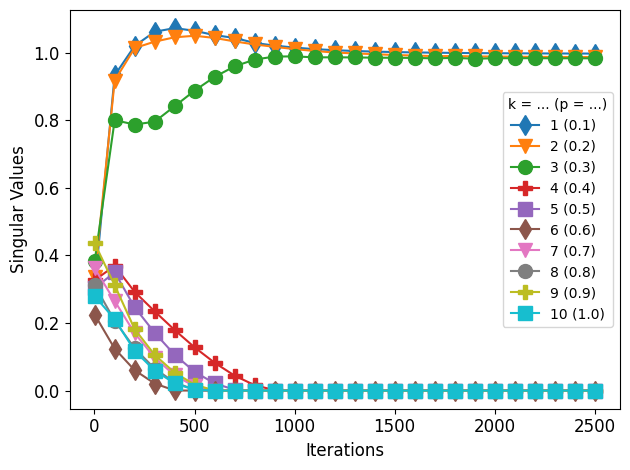

In [24]:

markers = ['d', 'v', 'o', 'P', 's', 'd', 'v', 'o', 'P', 's']

x_vals = np.arange(len(importance_s[:,0])) * freq + 1
for k in range(m):
    plt.plot(x_vals, importance_s[:,k],'-', marker=markers[k], markersize=10)

plt.legend([str(k+1) + ' (' + str(round((k+1)/m, 1)) + ')' for k in range(m)], title=r'k = ... (p = ...)')
plt.ylabel('Singular Values', size=12)
plt.xlabel('Iterations', size=12)
plt.xticks(size=12)
plt.yticks(size=12)
plt.tight_layout()
# plt.savefig('../plots/pca_dim_drop.pdf')
plt.show()

In [25]:
importance_s[-1]

array([9.9765509e-01, 9.8746371e-01, 9.8349333e-01, 3.0708897e-08,
       3.6460289e-08, 1.8456994e-07, 4.4485027e-08, 2.8173682e-07,
       1.9759861e-07, 3.2521726e-07], dtype=float32)

### SVD + PCA: Maestro can recover actual importance

In [26]:
import numpy as np

import torch
from torch import nn

from maestro.layers.linear import MaestroLinear

In [27]:
class LowRankFactorization(nn.Module):
    def __init__(self, m: int, n: int):
        super(LowRankFactorization, self).__init__()
        self.svd = MaestroLinear(m, n, bias=False)

    def forward(self, x, p=None):
        out = self.svd(x, p)
        return out


In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [29]:
m, n, h = 9, 6, 3
max_r = min(m, n)

# rank h matrix
torch.manual_seed(123)
C = torch.mm(torch.randn(m, h), torch.randn(h, n)).to(device)
U, S, Vh = torch.linalg.svd(C)

In [30]:
scaling = 1 / S[:h] * torch.tensor([1, 2, 3]).to(device)
X = torch.cat([scaling.reshape(-1, 1) * U.T[:h], U.T[h:]], dim=0)

In [31]:
lr = 10.
iters = 10000
freq = 500

In [32]:
model = LowRankFactorization(m, n).to(device)
optimiser = torch.optim.SGD(model.parameters(), lr=lr)

criterion = nn.MSELoss()

In [33]:
sampler = SingleLayerSampler(model)

eigenvalues = []

for it in range(iters):
    optimiser.zero_grad(set_to_none=True)

    p = sampler()

    out = model(X, p)
    loss = criterion(out, torch.mm(X, C))
    loss.backward()
    optimiser.step()

    if it % freq == 0 or it + 1 == iters:
        with torch.no_grad():
            output = model(X, None)
            loss = criterion(output, torch.mm(X, C))
            eigenvalues.append(
                (torch.norm(model.svd.in_network.weight, dim=1) * torch.norm(model.svd.out_network.weight, dim=0)).cpu().numpy()
            )
        print(f"{it + 1}/{iters}... Loss of full network:{loss.item()}")
eigenvalues = np.array(eigenvalues)

1/10000... Loss of full network:0.25351449847221375
501/10000... Loss of full network:0.00011587259359657764
1001/10000... Loss of full network:0.00012909798533655703
1501/10000... Loss of full network:3.4526823583291844e-05
2001/10000... Loss of full network:5.278227763483301e-05
2501/10000... Loss of full network:5.691207661584485e-06
3001/10000... Loss of full network:9.490670890954789e-06
3501/10000... Loss of full network:1.3083224530419102e-06
4001/10000... Loss of full network:3.6981844004913e-06
4501/10000... Loss of full network:1.1433170357122435e-06
5001/10000... Loss of full network:1.1177523902006214e-06
5501/10000... Loss of full network:9.111245731219242e-07
6001/10000... Loss of full network:5.685415089828894e-07
6501/10000... Loss of full network:4.038617760215857e-07
7001/10000... Loss of full network:4.34834106499693e-07
7501/10000... Loss of full network:4.476254673591029e-07
8001/10000... Loss of full network:3.7387519569165306e-07
8501/10000... Loss of full networ

In [34]:
torch.norm(model.svd.in_network.weight, dim=1) * torch.norm(model.svd.out_network.weight, dim=0)

tensor([3.6651, 6.9243, 9.5494, 0.0127, 0.0315, 0.0637], device='cuda:0',
       grad_fn=<MulBackward0>)

In [35]:
%matplotlib inline

import matplotlib.pyplot as plt

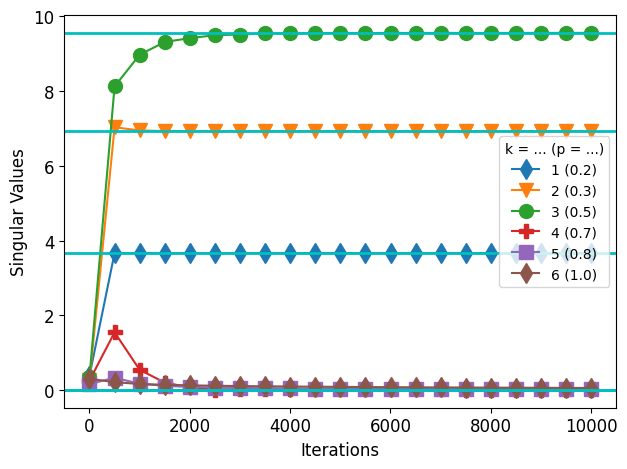

In [36]:
markers = ['d', 'v', 'o', 'P', 's', 'd', 'v', 'o', 'P', 's']

eigvals = S.cpu().numpy()
x_vals = np.arange(len(eigenvalues[:, 0])) * freq + 1
for k in range(max_r):
    plt.plot(x_vals, eigenvalues[:, k],'-', marker=markers[k], markersize=10)

for eigval in eigvals:
    plt.axhline(y=eigval, color='c', linewidth=2.)
plt.legend([str(k+1) + ' (' + str(round((k+1)/max_r, 1)) + ')' for k in range(max_r)], title=r'k = ... (p = ...)')
plt.ylabel('Singular Values', size=12)
plt.xlabel('Iterations', size=12)
plt.xticks(size=12)
plt.yticks(size=12)
plt.tight_layout()
# plt.savefig('../plots/svd_actual_importance.pdf')
plt.show()